## 1.2.5a. overlap Nestorowa dataset

In this Notebook we will compare our dataset with the another published dataset, namely the dataset published in Nestorowa et al. 2016 (https://doi.org/10.1182/blood-2016-05-716480
). Their preprocessed and filtered count matrix can be found using GEO code GSE81682 (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE81682). Here, you can download the GSE81682_HTSeq_counts.txt.gz file. 

In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd

# single cell libraries
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 0 

# plotting libraries
from matplotlib import pyplot as plt

# other 
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization
import scipy #for making sparse matrix from dense
import mygene #for converting ENSEMBL IDs to gene names
import os #to get absolute path of file

# import own functions
from utils import *

In [2]:
### load R into Notebook 
%load_ext rpy2.ipython 

### Load data

First, we load the filtered control subset (as filtered in notebook 1.1).

In [3]:
### load Anndata object with the control subset 
adata_path = "../data/count_matrices/control_filtered.h5ad"
adata = sc.read_h5ad(adata_path)

Then, we load the Nestorowa data. The genes in the Nestorowa dataset are named with their Ensembl gene ID. Because the genes in our own dataset are named using their gene names, we will convert the ENSEMBL gene IDs to gene names.

To do so, we will use the package mygene and convert each ENSEMBL ID to it's corresponding gene name. This takes quite some time, so we commented the code out and instead, we recommend you to just use the csv file we uploaded on the Github Repository ("data/public_datasets/Nestorowa_2016/ENSMBL_and_gene_names.csv"). 

In [4]:
### load Nestorowa data in dataframe
nesto_data_path = "../data/public_datasets/Nestorowa_2016/HTSeq_counts.txt"
nesto_data = pd.read_csv(nesto_data_path, index_col=0, sep="\t")
nesto_data = nesto_data.T

In [5]:
### remove rows that are not genes
nesto_data = nesto_data.iloc[:,nesto_data.columns.str.startswith('ENSMUS')]

In [6]:
### convert ENSEMBL IDs to gene names
#mg = mygene.MyGeneInfo()
#genes_list = list(nesto_data.columns)
#conversion_table = mg.querymany(genes_list , scopes='ensemblgene',
#                                fields='symbol', species='mouse',
#                                as_dataframe=True, verbose=False)

### remove duplicates in converstion table
#conversion_table = conversion_table.drop_duplicates(subset="query", keep="first")

### save ENSEMBL IDs and gene names for future uses
#save_path = "../data/public_datasets/Nestorowa_2016/ENSMBL_and_gene_names.csv"
#conversion_table.to_csv(save_path, header=True, index=True)

In [7]:
### load tabel vor ENSEMBL ID to gene name conversion
gene_conversion_path = "../data/public_datasets/Nestorowa_2016/ENSMBL_and_gene_names.csv"
conversion_table = pd.read_csv(gene_conversion_path, index_col=1)

In [8]:
### exchange ENSEMBL for gene symbols
nesto_data.columns = conversion_table.loc[nesto_data.columns,"symbol"].values

In [9]:
### remove genes that do not have a gene symbol
nesto_data = nesto_data.loc[:,nesto_data.columns.notnull()]

In [10]:
### remove genes that are duplicated
nesto_data = nesto_data.loc[:,~nesto_data.columns.duplicated()]

Now, we will apply the filtering steps that we have also applied to the control dataset.

In [11]:
### create Anndata object with Nestorowa data
adata_nesto = ad.AnnData(X=nesto_data)

In [12]:
### make sparse matrix
adata_nesto.X = scipy.sparse.csr_matrix(adata_nesto.X)

In [13]:
### preprocess Nestorowa data
adata_nesto = filter_data(adata_nesto, mito_perc=5, min_genes=700, no_doublet=False, no_negative=False)

Trying to set attribute `.obs` of view, copying.


The Nestorowa dataset comes with some additional metadata files which you can find here: http://blood.stemcells.cam.ac.uk/data/. We will download the file with the cell types ("all_cell_types.txt"). You can find a copy of this file in our Github Repository as well. 

In [14]:
### load cell types
celltypes_path = "../data/public_datasets/Nestorowa_2016/all_cell_types.txt"
celltypes = pd.read_csv(celltypes_path, sep="\t", index_col=0)

### get cell types (broad gating)
celltypes_broad = celltypes.iloc[:,celltypes.columns.str.endswith('broad')]
celltypes_broad = celltypes_broad.idxmax(axis=1)

### get cell types (narrow gating)
celltypes_narrow = celltypes.iloc[:,~celltypes.columns.str.endswith('broad')]
celltypes_narrow = celltypes_narrow.idxmax(axis=1)

In [15]:
### add cell types to Nestorowa data
adata_nesto.obs["celltypes_broad"] = celltypes_broad
adata_nesto.obs["celltypes_narrow"] = celltypes_narrow

In [16]:
### load diffusion map coordinates
coordinates_path = "../data/public_datasets/Nestorowa_2016/diffusionMapCoords.txt"
coordinates = pd.read_csv(coordinates_path, index_col=0, sep=" ")

In [17]:
### subset Nestrowa dataset for cells that are included in coordinates
shared_cells = np.intersect1d(coordinates.index, adata_nesto.obs_names)
adata_nesto = adata_nesto[shared_cells,:]

In [18]:
### add diffusion map coordinates to Baccin data
adata_nesto.obsm["X_tsne"] = coordinates.loc[adata_nesto.obs_names.values]

... storing 'celltypes_broad' as categorical
... storing 'celltypes_narrow' as categorical


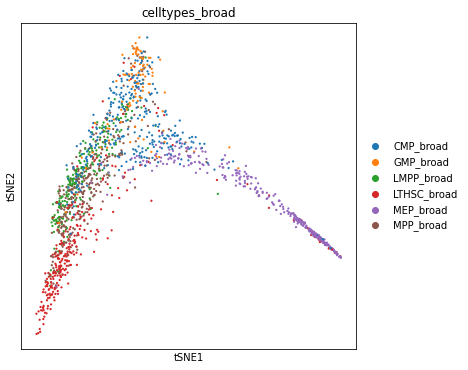

In [19]:
### plot Nestorowa data (cell types with broad gating)
fig, axs = plt.subplots(1, 1, figsize=(6,6))
sc.pl.tsne(adata_nesto, color="celltypes_broad", size=20, show=False, ax=axs)
plt.show()

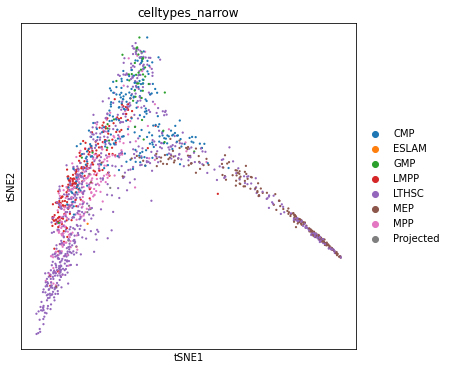

In [20]:
### plot Nestorowa data (cell types with narrow gating)
fig, axs = plt.subplots(1, 1, figsize=(6,6))
sc.pl.tsne(adata_nesto, color="celltypes_narrow", size=20, show=False, ax=axs)
plt.show()

### Combine control and Nestorowa dataset
To compare the control subset and the Nestorowa dataset, we have to combine the datasets. First we will select the highly variable genes (HVGs) for both datasets individually. We will select only those genes in both datasets. Then, we combine the two datasets. Afterwards we normalize the dataset. These steps are very similar to the preprocessing that we perform on the complete HSC dataset in the Jupyter Notebook 1.3.

In [21]:
### find shared genes
shared_genes = adata.var_names.intersection(adata_nesto.var_names)

### subset for shared genes
adata = adata[:, shared_genes]
adata_nesto = adata_nesto[:, shared_genes]

In [22]:
### get HVGs for both datasets
hvgs_HSPC = get_hvgs(adata, no_of_hvgs=2000, theta=100)
hvgs_nesto = get_hvgs(adata_nesto, no_of_hvgs=2000, theta=100)
hvgs = np.unique(np.concatenate([hvgs_HSPC, hvgs_nesto]))

### subset for HVGs
adata = adata[:, hvgs]
adata_nesto = adata_nesto[:, hvgs]

In [23]:
### combine datasets
combined = adata.concatenate(adata_nesto, batch_key="dataset", 
                             batch_categories=["control", "Nestorowa"])

In [24]:
### L2 normalize dataset
combined.X = sk.preprocessing.normalize(combined.X, norm='l2')

### Integrate the two datasets

Here, we will integrate the two datasets. In other notebooks (such as 1.2.4b and 1.3) we use Scanorama for integrating/ batch correction of datasets. In this case, with the Nestorowa dataset, the Scanorama method was not enough to integrate the two datasets, so we opt for the Seurat integration instead. In order to use R functions (such as Seurat) inside this notebook, we will make use of the rpy2 package (which was loaded in the second box of this notebook). 

In [25]:
### save the combined Anndata object 
#(so we can convert it to a Seurat object)
name_file = "control_and_Nestorowa_combined.h5ad"
adata_path  = f"../data/public_datasets/Nestorowa_2016/{name_file}"
combined.write_h5ad(adata_path)

... storing 'hashtags' as categorical
... storing 'clusters' as categorical
... storing 'celltypes_broad' as categorical
... storing 'celltypes_narrow' as categorical


In [26]:
### get absolute path of anndata object
adata_path = os.path.abspath(adata_path)

In [27]:
%%R -i adata_path 

### load packages
library(Seurat) 
library(SeuratDisk)

### load dataset
dataset_dir <- adata_path

### convert h5ad to h5seurat 
Convert(dataset_dir, 
        paste0(tools::file_path_sans_ext(dataset_dir), ".h5seurat"), 
        overwrite = TRUE)

### load h5seurat file
combined <- LoadH5Seurat(paste0(tools::file_path_sans_ext(dataset_dir), ".h5seurat"))

### Seurat batch correction
protocol.list <- SplitObject(combined, split.by = "dataset")
reference.list <- protocol.list[c("control","Nestorowa")]
protocol.anchors <- FindIntegrationAnchors(object.list = reference.list, dims = 1:30)
batch.integrated <- IntegrateData(anchorset = protocol.anchors, dims = 1:30)

### save batch corrected "count" matrix
counts <- batch.integrated@assays[["integrated"]]@data
counts <- as.data.frame(counts)
counts <- t(counts)
counts_save_path <- paste0(file_path_sans_ext(adata_path), "_batch_corrected.txt")
write.csv(counts, counts_save_path)

R[write to console]: Attaching SeuratObject

R[write to console]: Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

R[write to console]: Warnung:
R[write to console]:  Unknown file type: h5ad

R[write to console]: Warnung:
R[write to console]:  'assay' not set, setting to 'RNA'

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding X as data

R[write to console]: Adding X as counts

R[write to console]: Adding meta.features from var

R[write to console]: Validating h5Seurat file

R[write to console]: Initializing RNA with data

R[write to console]: Adding counts for RNA

R[write to console]: Adding feature-level metadata for RNA

R[write to console]: Adding command information

R[write to console]: Adding cell-level metadata

R[write to console]: Adding miscellaneous information

R[write to console]: Adding tool-specific results

R[write to console]: Computing 2000 integration features

R[w

  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


R[write to console]: Finding all pairwise anchors



  |                                                  | 0 % ~calculating  

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 4778 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 2800 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=35s  


R[write to console]: Merging dataset 2 into 1

R[write to console]: Extracting anchors for merged samples

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to con

In [28]:
%%R -o counts_save_path

### export counts_save_path

NULL


In [29]:
### load batch corrected counts
corrected_counts = pd.read_csv(counts_save_path[0], index_col=0)

In [30]:
### add corrected counts to combined Anndata object
combined.obsm["X_seurat"] = corrected_counts

### reduce dimensions of corrected counts
combined.obsm["X_seurat_reduced"] = sc.tl.pca(combined.obsm["X_seurat"], n_comps=50)

### UMAP representation of data
Here we will use the integrated data to calculate the UMAP representation of the 2 datasets combined.

In [31]:
### calculate NN
sc.pp.neighbors(combined, n_neighbors=20, n_pcs=50, use_rep = "X_seurat_reduced")

In [32]:
### calculate UMAP 
sc.tl.umap(combined)

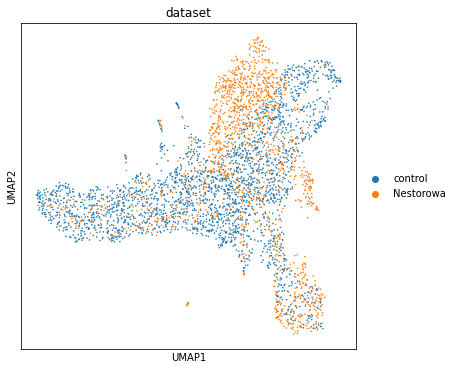

In [33]:
### plot both datasets in UMAP 
fig, axs = plt.subplots(1, 1, figsize=(6,6))
sc.pl.umap(combined, color="dataset", size=10, ax=axs, show=False)
plt.show()

In [34]:
### set the correct colours for each cluster
color_dict = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))
color_dict['nan']="#cfcfcf"
combined.uns["clusters_colors"] = combined.obs["clusters"].cat.categories.map(color_dict).values

color_dict = dict(zip(adata_nesto.obs["celltypes_broad"].cat.categories, adata_nesto.uns["celltypes_broad_colors"]))
color_dict['nan']="#cfcfcf"
combined.uns["celltypes_broad_colors"] = combined.obs["celltypes_broad"].cat.categories.map(color_dict).values

color_dict = dict(zip(adata_nesto.obs["celltypes_narrow"].cat.categories, adata_nesto.uns["celltypes_narrow_colors"]))
color_dict['nan']="#cfcfcf"
combined.uns["celltypes_narrow_colors"] = combined.obs["celltypes_narrow"].cat.categories.map(color_dict).values

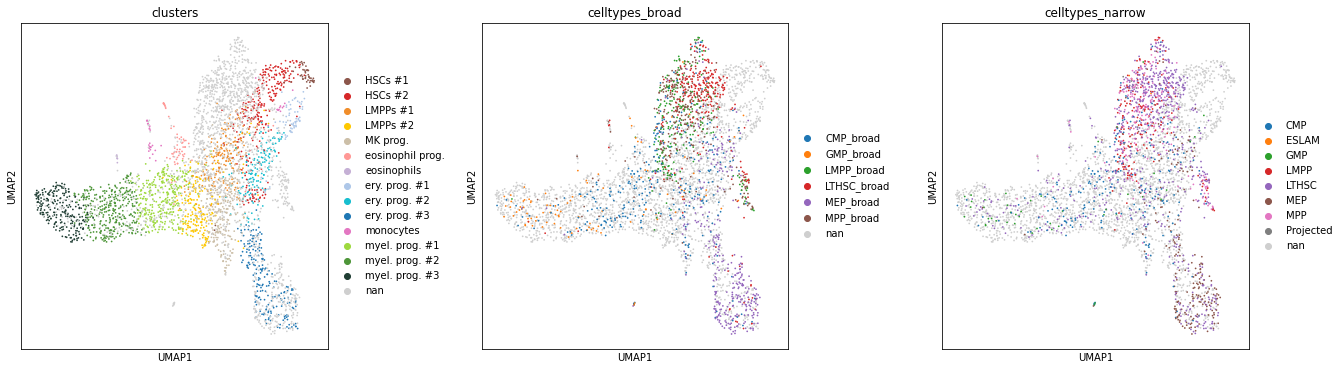

In [35]:
### plot both datasets (Nestorowa two times)
fig, axs = plt.subplots(1, 3, figsize=(22,6), gridspec_kw={'wspace':0.5})
sc.pl.umap(combined, color="clusters", size=12, ax=axs[0], show=False)
sc.pl.umap(combined, color="celltypes_broad", size=12, ax=axs[1], show=False)
sc.pl.umap(combined, color="celltypes_narrow", size=12, ax=axs[2], show=False)
axs[0].legend(bbox_to_anchor=(1, 0.5), loc='center left', framealpha=0.0)
plt.show()

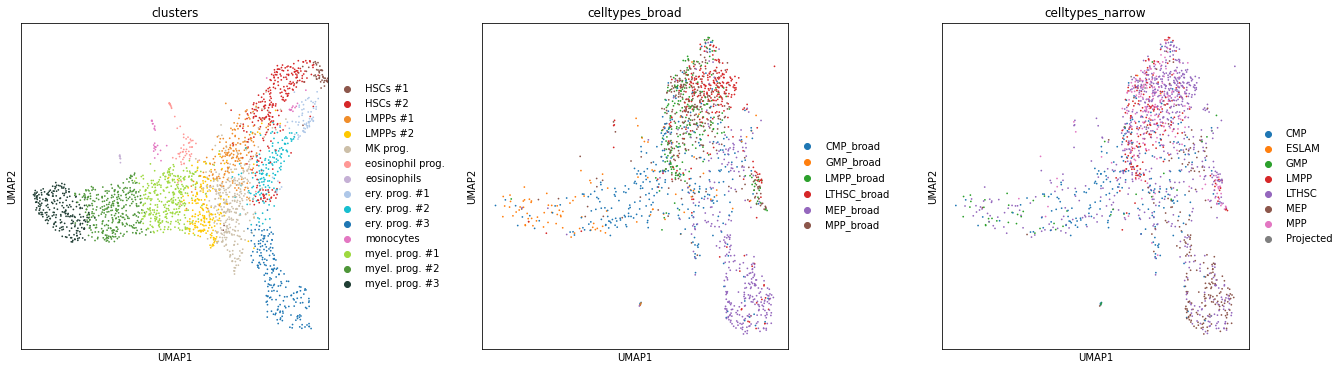

In [36]:
### plot both datasets seperately with colors for clusters
fig, axs = plt.subplots(1, 3, figsize=(22,6), gridspec_kw={'wspace':0.5})
sc.pl.umap(combined[combined.obs["dataset"]=="control"], color="clusters", size=12, ax=axs[0], show=False)
sc.pl.umap(combined[combined.obs["dataset"]=="Nestorowa"], color="celltypes_broad", size=12, ax=axs[1], show=False)
sc.pl.umap(combined[combined.obs["dataset"]=="Nestorowa"], color="celltypes_narrow", size=12, ax=axs[2], show=False)
axs[0].legend(bbox_to_anchor=(1, 0.5), loc='center left', framealpha=0.0)
axs[0].set_ylim(axs[1].get_ylim())
axs[0].set_xlim(axs[1].get_xlim())
plt.show()

### Label transfer

Here we transfer the labels from the Nestorowa dataset to the control subset. We use the reduced Seurat space to find the nearest neighbours of each control cell in the Nestorowa dataset. Then, we assign the label that is most common among the nearest neighbours to the selected cell.

In [37]:
### transfer labels from Nestorowa dataset to control subset
labels = label_transfer(combined, batch_key="dataset", 
                        basis='X_seurat_reduced',
                        label_key="celltypes_broad",
                        reference="Nestorowa", query="control", no_neighbours=10)

In [38]:
### add transferred labels to control subset
adata.obs["transferred_labels"] = labels.values

Trying to set attribute `.obs` of view, copying.


In [39]:
### set the correct colours for each cell type
color_dict = dict(zip(adata_nesto.obs["celltypes_broad"].cat.categories, adata_nesto.uns["celltypes_broad_colors"]))
adata.uns['transferred_labels_colors'] = adata.obs["transferred_labels"].cat.categories.map(color_dict).values

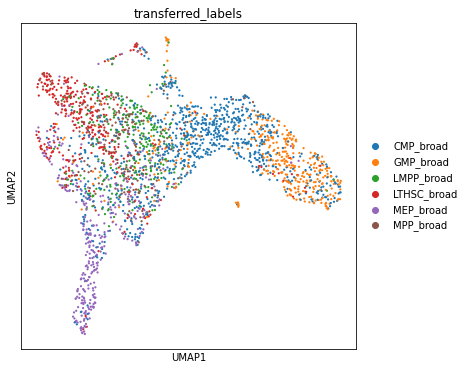

In [40]:
### UMAP with transferred labels
fig, axs = plt.subplots(1, 1, figsize=(6,6))
sc.pl.umap(adata, color="transferred_labels", size=20, show=False, ax=axs)
plt.show()